# Agile semi-automatic image clustering (filtering) using pre-trained Convolutional Neural Networks and clustering algorithms
### Authors: Michał Woźniak (id: 385190), Michał Wrzesiński (id: 385197)
### Date: 14.11.2019

In [95]:
#setting width of jupyter notebook document to 80%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 1. Introduction
## 1.1 Background
Currently, deep neural networks are used in many areas. One of them is the Computer Vision. More and more commercial companies are deciding to use these technologies to solve their daily problems and tasks. They usually decide to outsource a project to a data science consulting company. This consulting company is given limited time (always around 3-6 months) to prepare a code that will serve as a Proof of Concept or Most Valuable Product. Therefore, the race against time begins.
<br><br>
As everyone knows, know-how alone is not enough. The key is correct and reliable preparation of data for analysis and learning. Very often, customers specify their requirements and set business goals, but at the same time provide data in very poor quality. In the case of photos, it is usually a large number of images that are not useful in the analysis and should be discarded at the very beginning of the study. Clients usually do a snapshot of data from databases and do not care what they are providing to machine learning consultants. In this situation you have to manage somehow. By nature, it would not be optimal to filter photos manually. Usually, such work is outsourced to a low-skilled person to reduce the cost of their remuneration. However, it happens that regular scientists do such exercises during the project because of the scale of the problem and time, which is required to employ low-skilled worker. So far in practice, not developed a good methodology of fighting this problem. This article may be the solution.
## 1.2 Purpose of the study
In this paper authors would like to propose new approach to removing unneeded images from databases, which will later be used to train machine learning algorithms. Their goal was to develop a semi-automatic solution based on pre-trained convolutional neural networks and clustering algorithms that would be fast, precise and robust in image clustering. The word fast means the lack of carrying out the learning process. This assumption enables scientists to quickly prototype during a commercial project. Precision and robustness address the issue of algorithm resistance to various types and classes of images. The simplest solution would seem to be the use of pre-trained convolutional neural networks with the top soft-max layer. However, this network is only trained for approximately 1,000 classes on ImageNet dataset. Therefore, it is useful for a strictly defined number of cases (1000). In this paper researchers are proposing to turn off a top layer of the network and treat CNN as a tool dedicated to feature extraction from images. That's why the approach presented in this article is not limited to any number of classes. The only condition and assumption is to define clearly distinguishable classes before starting the analysis (e.g. by receiving a data set from the Vienna Zoo we want to perform segmentation that will divide the set into animals and their food, and runs - as you can see the classes are distinguishable). 
## 1.3 Scientific hypothesis
The major hypothesis verified in this paper is whether it is possible to construct fast, precise and robust semi-automatic algorithm for image clustering using pre-trained convolutional neural networks and unsupervised machine learning clustering algorithms?
## 1.4  Business hypothesis
In addition to the scientific hypothesis, a business hypothesis should also be stated because that takes into account the economic aspect of this study. The issue addressed in this article can be considered as a binary classification problem. Suppose company X hired company Y to conduct a PoC for the Computer Vision project. Company Y is considering whether to use the model proposed in this article or to hire a low qualified person to carry out the process of clustering the photos received from company X. <br><br> Company Y is experienced and knows that this decision will influence on the rest of the project, because it will affect the quality of the data. In this specific image case: if we assume that class 1 represents needed images and class 0 represents unneeded images: an increase of False Negative metric leads to a decrease of dataset size, while an increase in the False Positive metric increases the noise in the data. Both situation are undesirable. According to that, they found that they must optimize two metrics: <br><br>
\begin{equation*}
Precision = \frac{TP}{TP+FP}\\
\\and\\\\
Recall = \frac{TP}{TP+FN} 
\end{equation*}<br><br>
Finally they decided to use simple linear equation as Quality Metric of their work:<br><br>
\begin{equation*}
Quality Metric = 0.3 * Precision + 0.7 * Recall.
\end{equation*}<br>
This approach enables them to handle this particular business problem (Recall is much more important from their experience). Of course Company Y wants to maximize Quality Metric. <br><br>
Company Y knows that cost of hiring: 
* low qualified person is 20 PLN per hour
* highly qualified Data Scientist is 90 PLN per hour.

What is more they already obtained performance statistics when image clustering is performed by:
* low qualified person (fully manual approach) ~ 100 images per hour,
* highly qualified Data Scientist (semi-automatic approach using model from this paper) ~ 100 images per 10 minutes.

They realized that low qualified person can obtain Quality Metric = 0.95. This statistic is unknown for new approach. Company Y assumed that if Quality Metric is in range [0.9, 1.0], it will be worth to use new approach, because cost of low qualified person will be increasing in linear manor and cost of highly qualified person will be constant (it always gonna be 90PLN/6 = 15 PLN). But, otherwise they won't take that risk. Company Y calculate their savings. In case of:
* 100 images => savings =  5 PLN
* 1000 images => savings = 185 PLN
* 10000 images => savings = 1985 PLN
* 100000 images => savings = 19985 PLN
* etc.

According to that, impact is well visible. To sum up, the business hypothesis is: whether a new approach can obtain Quality Metric in range [0.9, 1.0]?

# 2 Methodology of the research
## 2.1 Unsupervised Machine Learning Algorithms
Scientists based on knowledge of the pros and cons of various unsupervised machine learning algorithms decided to inspect performance of: K-Means, DBSCAN and OTPICS in this problem. Below they posted short description of each considered algorithm.
### 2.1.1 K-Means
### 2.1.2 DBSCAN
### 2.1.3 OPTICS

## 2.2 Pre-trained Convolutional Neural Networks 
Scientists had to decide which CNN architecture they wanted to choose. Keras library provides the following pre-trained architectures on the ImageNet set:
* Xception
* VGG16
* VGG19
* ResNet
* ResNetV2
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet. 

According to their experience, accumulated expert knowledge and some researches: for example [Simone Bianco et al. from 2018](https://arxiv.org/pdf/1810.00736.pdf), they decided to use [Inception ResNet V2](https://arxiv.org/pdf/1602.07261.pdf), which is at the same time very efficient and precise. This model can be considered as a state of the art simultaneously with ResNet 152. To be more specific: Inception ResNet V2 is a variation of Inception V3 model which borrows some ideas from Microsoft's ResNet papers. Schematic diagram of Inception-ResNet-v2 ([source](https://ai.googleblog.com/2016/08/improving-inception-and-image.html)): <br><br>
![Schematic diagram of Inception-ResNet-v2](https://1.bp.blogspot.com/-O7AznVGY9js/V8cV_wKKsMI/AAAAAAAABKQ/maO7n2w3dT4Pkcmk7wgGqiSX5FUW2sfZgCLcB/s640/image00.png)<br><br>
What's important Keras implementation allow researchers to turn off top layer (soft-max) of pre-trained Inception ResNet V2 model. From technical point of view scientist have to keep in mind that default input size for this model is 299x299 pixels, so for sure some preprocessing is required.

## 2.3 Data
In this study, scientists simulated a project in the medical field. For the purposes of the paper, they created a data set consisting of 200 images (all converted to .png extension). The data was collected using Google Images. No ready dataset was used in the study. <br><br>In this specific collection there are clearly distinguishable 4 classes:
* medical documentation scans/images (like: prescriptions, discharges from hospitals, diagnoses, test results, etc.) - 50 images
* X-rays images - 50 images
* damaged limbs/organs images - 50 images
* other images (like: crashed cars, hospitals, safety suits, etc.). Below researchers are presenting some examples from each class - 50 images.

In [2]:
print("Medical documentation scans/images")
display(HTML("<table><tr><td><img src='../images/dataset/doc (10).png' height='500' width=500'></td><td><img src='../images/dataset/doc (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/doc (14).png' height='500' width=500'></td><td><img src='../images/dataset/doc (17).png' height='500' width=500'></td></tr></table>"))
print("X-rays images")
display(HTML("<table><tr><td><img src='../images/dataset/roentgen (10).png' height='500' width=500'></td><td><img src='../images/dataset/roentgen (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/roentgen (14).png' height='500' width=500'></td><td><img src='../images/dataset/roentgen (17).png' height='500' width=500'></td></tr></table>"))
print("Damaged limbs/organs images")
display(HTML("<table><tr><td><img src='../images/dataset/break (10).png' height='500' width=500'></td><td><img src='../images/dataset/break (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/break (8).png' height='500' width=500'></td><td><img src='../images/dataset/break (7).png' height='500' width=500'></td></tr></table>"))
print("Other images")
display(HTML("<table><tr><td><img src='../images/dataset/others (2).png' height='500' width=500'></td><td><img src='../images/dataset/others (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/others (14).png' height='500' width=500'></td><td><img src='../images/dataset/others (17).png' height='500' width=500'></td></tr></table>"))

Medical documentation scans/images


,


,


X-rays images


,


,


Damaged limbs/organs images


,


,


Other images


,


,


#### Warning: Not all data has been anonymized, so be careful not to publish this article prior to anonymization!!!
If you want inspect all images, they are located in "image/dataset/" folder.

## 2.4 Modeling approach - goal and  pipeline
Based on collected set, the main goal will be gathering medical documentation scans/images from database. The rest of images are irrelevant for future analysis of data scientist so they are redundant, thus this task converged to binary classification.
<br><br>
In this particular Computer Vision problem pipeline is quite simple:
* First of all prepared dataset needs to be loaded and preprocessed (resizing, dimension expanding, subtracting the mean RGB channels of the ImageNet dataset and etc.).
* Second step is application of Inception ResNet V2 (with frozen top layer) on every image in dataset. As a result of this procedure researchers should obtain list of extracted features for each image. 
* Third and the most crucial step is connected with unsupervised machine learning algorithms. Scientist will run and test performance of: K-Mmeas, DBSCAN, OPTICS on obtained features from images and will choose the best clustering model in this specific case. Procedure of running and testing consist of standard prediagnostics (like: Shilhouette, Elbow method, Hopkins' statistic etc.) and postdiagnostic (Rand Index) analysis. However, the most important during the judgment will be the metric defined in the subsection "1.4 Business hypothesis", i.e. Quality Metric. This metric will ultimately determine the best model.
* At the end it is necessary to sum up all results and propose final algorithm.

# 3 Modeling
Scientists commented almost every step which was realized by them.

#### Dependencies loading

In [71]:
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
import numpy as np
import glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pyclustertend import hopkins, vat, ivat
from sklearn.cluster import KMeans,DBSCAN,OPTICS
from pyclustering.cluster.kmedoids import kmedoids
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics.cluster import adjusted_rand_score

#### Obtaining names of all images from specified directory

In [4]:
files_list = glob.glob("../images/dataset/*.png")
len(files_list)

200

#### Image preprocessing in loop

In [5]:
preprocessed_images = dict() # dictionary for preprocessed images
for i in files_list:
    try:
        img_path = i
        img = image.load_img(img_path, target_size=(299, 299)) # loading image to PIL and resizing to (299x299)
        img_data = image.img_to_array(img) # transformin PIL image to numpy array and adding channels there
        img_data = np.expand_dims(img_data, axis=0) # transforming numpy array to tensor style - it implies new shape: number_of_images x width x height x channels
        img_data = preprocess_input(img_data) # subtracts the mean RGB channels of the ImageNet dataset and other adequations for model
        preprocessed_images.update({i:img_data}) # adding img_data to dictionary for preprocessed images
    except:
        print(f"Fatal error for {i} image")

#### InceptionResNetV2 model loading

In [6]:
model_cnn = InceptionResNetV2(weights='imagenet', include_top=False, classes=1000) #loading pre-trained model from Keras library without top layer
#model.summary() - print summary of model

#### Application of CNN model on previously preprocessed images

In [7]:
extracted_features = dict() # dictionary for extracted features for each image
for i,j in preprocessed_images.items():
    preds_features = np.array(model_cnn.predict(j)) # making prediction using InceptionResNetV2 model and saving it to numpy array
    extracted_features.update({i:preds_features.flatten()}) # collapsing array into one dimension

Printing shape and some extracted features for sample image 

In [8]:
print(list(extracted_features.values())[0].shape)
print("\n",(list(extracted_features.values())[0])[0:50]) #prining 50 first features for first image from dataset

(98304,)

 [ 2.0610640e+00 -0.0000000e+00 -0.0000000e+00  2.0123795e-03
 -0.0000000e+00 -0.0000000e+00  4.6042383e-02 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  1.5073717e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00  4.8915654e-02 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
  7.6898485e-02 -0.0000000e+00  7.0625097e-02 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  3.5666731e-01
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  2.3642561e-01  8.1343338e-02
  1.5015066e-01  4.6350241e-02  4.0756908e-01 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00]


In [9]:
df = pd.DataFrame.from_dict(extracted_features,orient="index") # creating Data Frame from dictionary - final dataset for clustering
df = df.add_prefix('feature_') # adding prefix

In [10]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_98294,feature_98295,feature_98296,feature_98297,feature_98298,feature_98299,feature_98300,feature_98301,feature_98302,feature_98303
../images/dataset\break (1).png,2.061064,-0.000000,-0.00000,0.002012,-0.00000,-0.000000,0.046042,-0.000000,-0.00000,-0.000000,...,-0.0,0.636658,2.878513,0.160079,-0.0,1.716022,-0.000000,-0.000000,0.434505,-0.00000
../images/dataset\break (10).png,-0.000000,0.239822,0.00437,-0.000000,-0.00000,-0.000000,-0.000000,0.018677,-0.00000,0.154725,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000
../images/dataset\break (11).png,1.871287,0.570042,-0.00000,0.806636,-0.00000,0.786878,0.025807,3.546529,1.97526,-0.000000,...,-0.0,0.462361,-0.000000,0.153095,-0.0,0.158004,-0.000000,0.752637,-0.000000,0.39443
../images/dataset\break (12).png,-0.000000,-0.000000,-0.00000,-0.000000,-0.00000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.412453,-0.000000,-0.000000,-0.00000
../images/dataset\break (13).png,-0.000000,-0.000000,-0.00000,-0.000000,1.30216,-0.000000,-0.000000,-0.000000,0.09370,-0.000000,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.459635,-0.000000,-0.000000,-0.000000,-0.00000


In [11]:
df.shape

(200, 98304)

Obtained dataset has 200 observations (rows) and 98304 features (columns). It seems to be decent dataset for clustering exercise. 

#### Creating new column: "class", which represents class of image

In [12]:
def get_class(x):
    x, _ = x.split(" ")
    _, x = x.split("\\")
    return x

df["class"] = df.index.copy()
df["class"] = df["class"].apply(get_class)

In [13]:
df.sample(5) #prinint 5 random rows to see result of above maping

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_98295,feature_98296,feature_98297,feature_98298,feature_98299,feature_98300,feature_98301,feature_98302,feature_98303,class
../images/dataset\others (32).png,-0.0,-0.000000,-0.000000,-0.0,0.072971,-0.000000,-0.0,-0.0,-0.0,-0.000000,...,0.714459,-0.000000,-0.000000,-0.000000,-0.000000,0.395584,-0.0,-0.0,-0.000000,others
../images/dataset\roentgen (48).png,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,roentgen
../images/dataset\others (15).png,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,0.374695,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.096987,-0.0,-0.0,-0.000000,others
../images/dataset\doc (24).png,-0.0,-0.000000,-0.000000,-0.0,-0.000000,0.337864,-0.0,-0.0,-0.0,0.099063,...,-0.000000,0.077474,0.552405,0.596421,0.237112,-0.000000,-0.0,-0.0,0.270871,doc
../images/dataset\doc (12).png,-0.0,0.068787,0.305308,-0.0,0.339380,-0.000000,-0.0,-0.0,-0.0,0.830358,...,-0.000000,-0.000000,-0.000000,-0.000000,0.507539,-0.000000,-0.0,-0.0,0.372980,doc


In [14]:
df.info() #checking memory usage (RAM) for dataset - it's only 150.0+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, ../images/dataset\break (1).png to ../images/dataset\roentgen (9).png
Columns: 98305 entries, feature_0 to class
dtypes: float64(98304), object(1)
memory usage: 150.0+ MB


In [18]:
# df.to_csv("dataset.csv") # saving dataset to repository

#### Dataset visualization (images embedded in the new space) using PCA 

Data preparation and PCA applying

In [15]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df.iloc[:,:-1])
df_pca = pd.DataFrame(principalComponents,columns=["pc1","pc2"])
df_pca["class"] = df["class"].values

Nice ploting of PCA results

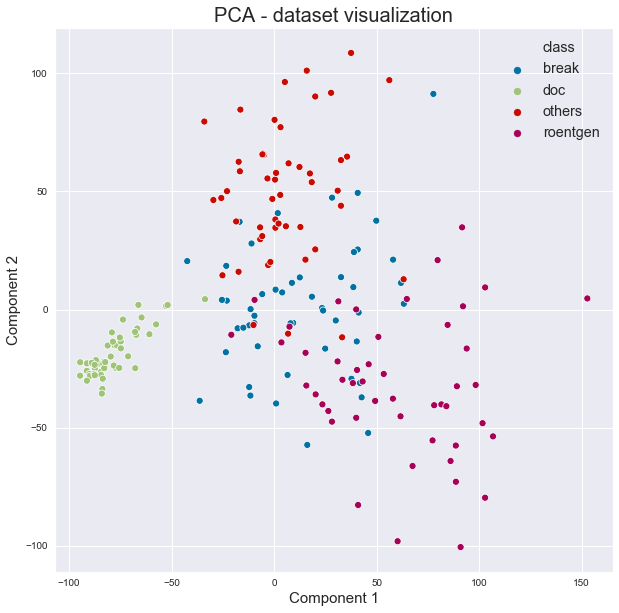

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plot = sns.scatterplot(df_pca.pc1,df_pca.pc2,df_pca["class"],s=50)
plot.axes.set_title('PCA - dataset visualization',fontsize=20)
plot.set_xlabel("Component 1",fontsize=15)
plot.set_ylabel("Component 2",fontsize=15)
plot.legend(fontsize='x-large', title_fontsize='20')
plt.show()

It's clearly visible on above plot that classes are distinguishable (especially medical documents and others images). However, X-Rays and images of injuries penetrate significantly each other. Additionally prediagnostics will be considered to receive more informations about clusters.

#### Hopkins statistic and visual assessment of cluster tendency

Calculation of Hopkins statistic is highly ineffective on big dataset, so two sampling sizes will be provided to obtain robustness of this analysis. 

In [127]:
clust_tendency = scale(df.iloc[:,:-1])
print("Hopkins statistic",hopkins(clust_tendency,25)) ## Hopkins statistic with 25 sampling size

Hopkins statistic 0.2046101436925963


In [128]:
clust_tendency = scale(df.iloc[:,:-1])
print("Hopkins statistic",hopkins(clust_tendency,50)) ## Hopkins statistic with 50 sampling size

Hopkins statistic 0.2199592198129442


Hopkins statistic in both attempts returns: ~ 0.20. It's closer to 0 than 0.5, thus the null hypothesis should be accepted: "the dataset is uniformly distributed" (unlikely that there are statistically significant clusters).

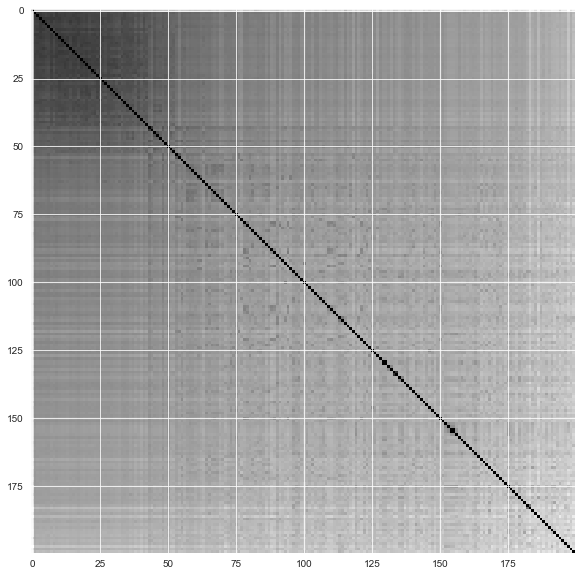

In [126]:
vat(df.iloc[:,:-1],) #visual assessment of cluster tendecy plot

Visual Assessment of Cluster Tendecy suggests that dataset is hard to segmentation. Plot is dominated by light gray which represents high dissimilarity in data (low similarity), only small part can be characterized as high similarity points - potentially belong to one cluster.  

#### K-Means 

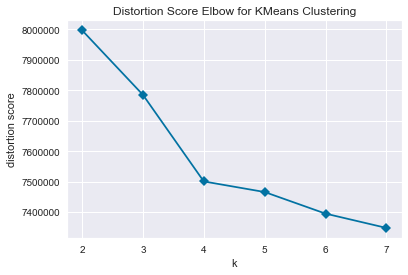

In [73]:
model = KMeans(random_state=2018)
visualizer = KElbowVisualizer(model, k=(2,8),metric='distortion',timings=False,locate_elbow=False)
visualizer.fit(df.iloc[:,:-1]) 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_style("darkgrid")
visualizer.show()

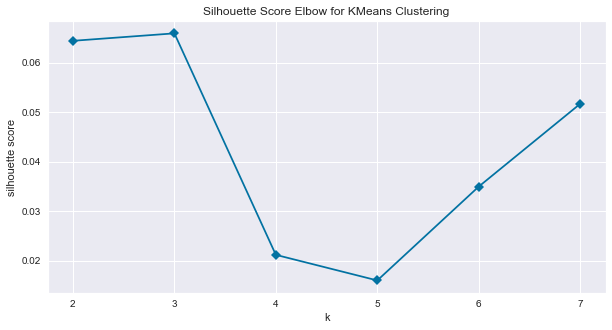

In [94]:
model = KMeans(random_state=2018)
visualizer = KElbowVisualizer(model, k=(2,8),metric='silhouette',timings=False,locate_elbow=False)
visualizer.fit(df.iloc[:,:-1]) 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_style("darkgrid")
visualizer.show()

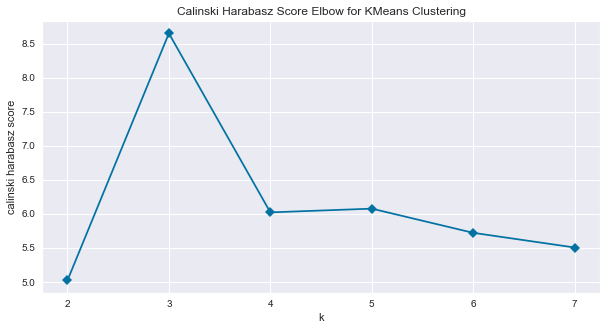

In [75]:
model = KMeans(random_state=2018)
visualizer = KElbowVisualizer(model, k=(2,8),timings=False,locate_elbow=False,metric="calinski_harabasz")
visualizer.fit(df.iloc[:,:-1]) 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_style("darkgrid")
visualizer.show()

#### NIe moje: to sugestie co pisać
By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center. However, two other metrics can also be used with the KElbowVisualizer – silhouette and calinski_harabasz. The silhouette score calculates the mean Silhouette Coefficient of all samples, while the calinski_harabasz score computes the ratio of dispersion between and within clusters.
It is important to remember that the “elbow” method does not work well if the data is not very clustered. In this case, you might see a smooth curve and the optimal value of 

In [51]:
def clustering_plot(model_,title): 
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df.iloc[:,:-1])
    df_pca = pd.DataFrame(principalComponents,columns=["pc1","pc2"])
    df_pca["class"] = df["class"].values

    labels = model_.fit_predict(df.iloc[:,:-1])
    df_pca["cluster"] = labels
    
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,10))
    plot = sns.scatterplot(df_pca.pc1,df_pca.pc2,df_pca["cluster"],s=50,style=df_pca["class"], palette="Set2",legend='full')
    plot.axes.set_title(f'{title}',fontsize=20)
    plot.set_xlabel("Component 1",fontsize=15)
    plot.set_ylabel("Component 2",fontsize=15)
    plot.legend(fontsize='x-large', title_fontsize='20')
    plt.show()

In [52]:
kmeans1 = KMeans(n_clusters=2, random_state=2019)

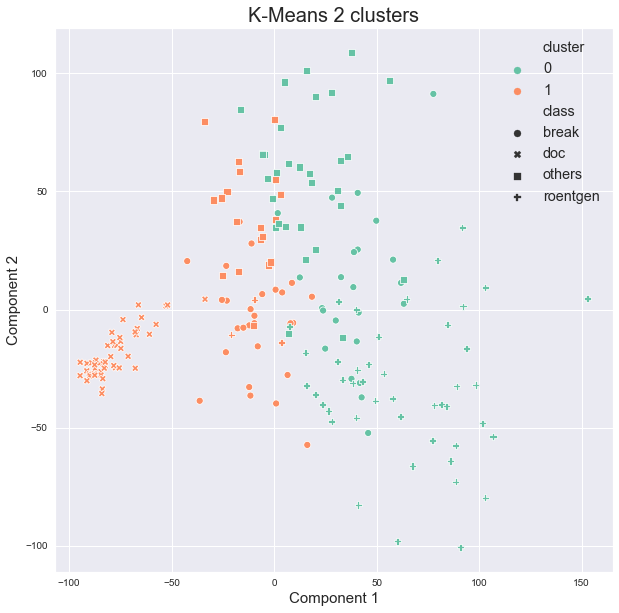

In [53]:
clustering_plot(kmeans1,"K-Means 2 clusters")

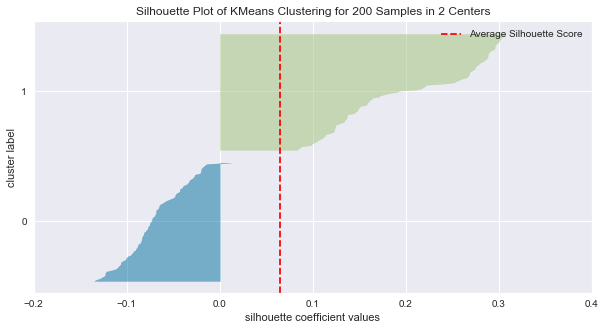

In [54]:
plt.rcParams['figure.figsize'] = [10, 5]
visualizer = SilhouetteVisualizer(kmeans1, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

In [55]:
kmeans2 = KMeans(n_clusters=3, random_state=2019)

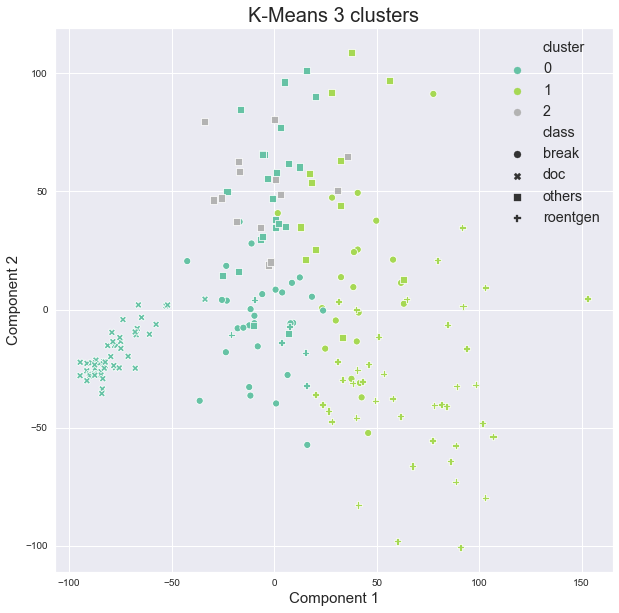

In [56]:
clustering_plot(kmeans2,"K-Means 3 clusters")

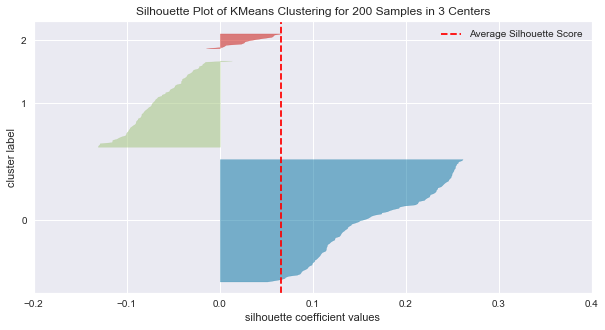

<Figure size 720x720 with 0 Axes>

In [57]:
visualizer = SilhouetteVisualizer(kmeans2, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
plt.figure(figsize=(10,10))
visualizer.show()

In [63]:
kmeans3 = KMeans(n_clusters=5, random_state=2019)

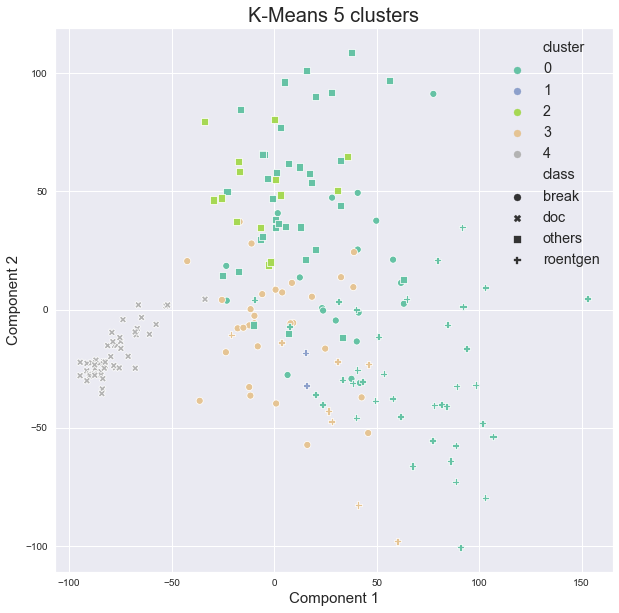

In [64]:
clustering_plot(kmeans3,"K-Means 5 clusters")

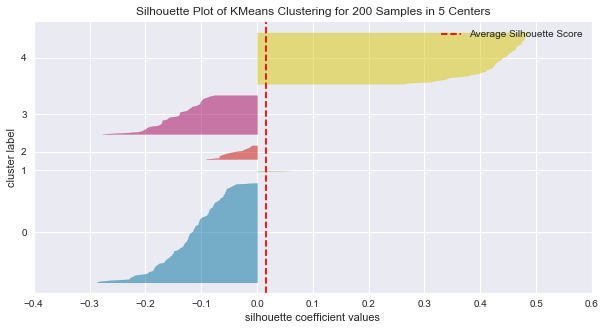

In [65]:
visualizer = SilhouetteVisualizer(kmeans3, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

In [66]:
kmeans4 = KMeans(n_clusters=6, random_state=2019)

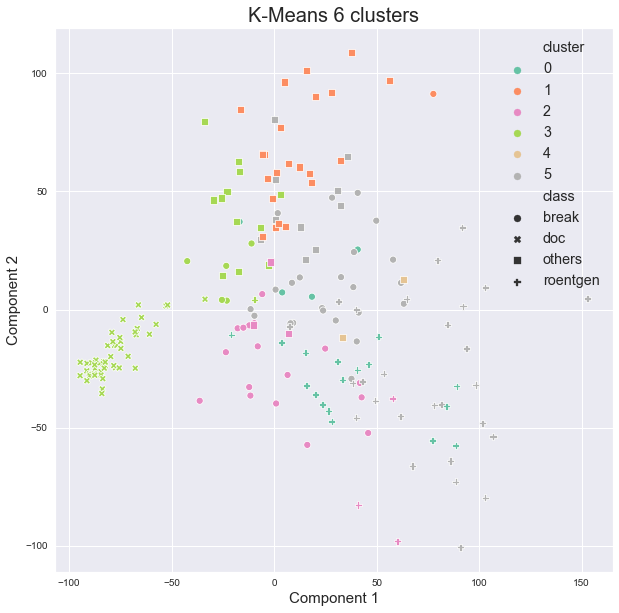

In [67]:
clustering_plot(kmeans4,"K-Means 6 clusters")

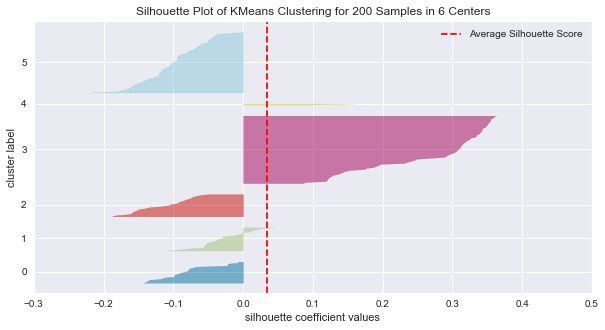

In [68]:
visualizer = SilhouetteVisualizer(kmeans4, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

najistotniejsze jest analiza silhuetu dla naszego kluczowego klastra który chcemy wyciągnąć

In [70]:
adjusted_rand_score(kmeans3.fit_predict(df.iloc[:,:-1]),kmeans4.fit_predict(df.iloc[:,:-1]))

0.32908811274319727

In [91]:
df_kmeans_final = df.copy()
labels = kmeans3.fit_predict(df.iloc[:,:-1])
df_kmeans_final["cluster"] = labels
df_kmeans_final[df_kmeans_final["class"]=="doc"]["cluster"].value_counts()

4    50
Name: cluster, dtype: int64

In [93]:
𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 1
Recall = 1 
𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐=0.3 * Precision + 0.7 * Recall
print("𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 = ",𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐)

𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 =  1.0


#### DBSCAN

#### OPTICS

#### Comparison of results obtained by: KMeans, DBSCAN, OPTICS 

#### Proposed algorithm

# Conclusions
## SH and BH:

In [ ]:
https://mybinder.org/